In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [7]:

# Para leerlos de un jalon
DATA = Path("../data/raw")
files = [
    "sales_train.csv",
    "test.csv",
    "items.csv",
    "item_categories.csv",
    "shops.csv",
    "sample_submission.csv",
]

dfs = {}
for f in files:
    p = DATA / f
    if p.exists():
        dfs[f] = pd.read_csv(p)
    else:
        print("No encontré:", p)

list(dfs.keys())


['sales_train.csv',
 'test.csv',
 'items.csv',
 'item_categories.csv',
 'shops.csv',
 'sample_submission.csv']

In [8]:
train = dfs["sales_train.csv"].copy()
test  = dfs["test.csv"].copy()
items = dfs["items.csv"][["item_id","item_category_id"]].copy()

In [9]:
# agración mensual
monthly = (train
           .groupby(["date_block_num","shop_id","item_id"], as_index=False)
           .agg(item_cnt_month=("item_cnt_day","sum"),
                avg_price=("item_price","mean")))



In [10]:
monthly.item_cnt_month.max()

np.float64(2253.0)

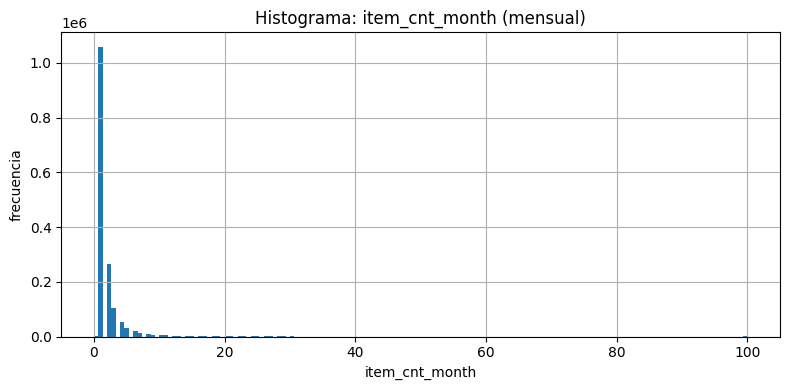

In [11]:
plt.figure(figsize=(8,4))
monthly["item_cnt_month"].clip(0, 100).hist(bins=150)
plt.title("Histograma: item_cnt_month (mensual)")
plt.xlabel("item_cnt_month")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.show()

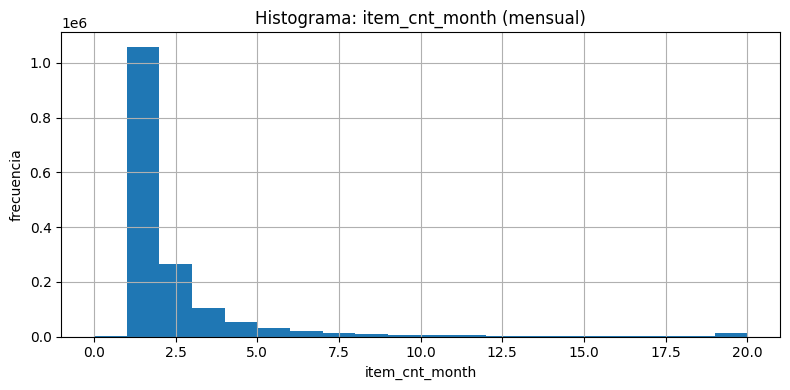

In [12]:
# debido a que "True target values are clipped into [0,20] range."
plt.figure(figsize=(8,4))
monthly["item_cnt_month"].clip(0, 20).hist(bins=20)
plt.title("Histograma: item_cnt_month (mensual)")
plt.xlabel("item_cnt_month")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.show()

In [13]:
monthly["item_cnt_month"] = monthly["item_cnt_month"].clip(0, 20)

In [14]:
monthly = monthly.merge(items, on="item_id", how="left")

last_block = int(monthly["date_block_num"].max())
test_block= last_block+1
test_base = test.copy()
test_base["date_block_num"] = test_block

base = pd.concat([
    monthly[["date_block_num","shop_id","item_id","item_cnt_month","avg_price","item_category_id"]],
    test_base.merge(items, on="item_id", how="left")[["date_block_num","shop_id","item_id","item_category_id"]]
], ignore_index=True, sort=False)

In [15]:
base

,date_block_num,shop_id,item_id,item_cnt_month,avg_price,item_category_id
0,0,0,32,6.0,221.0,40
1,0,0,33,3.0,347.0,37
2,0,0,35,1.0,247.0,40
3,0,0,43,1.0,221.0,40
4,0,0,51,2.0,128.5,57
...,...,...,...,...,...,...
1823319,34,45,18454,NaN,NaN,55
1823320,34,45,16188,NaN,NaN,64
1823321,34,45,15757,NaN,NaN,55
1823322,34,45,19648,NaN,NaN,40


In [16]:

# Creación de variables simples, no dio tiempo de mucho se asumen que vendran mejoras
# adicional es algo similar a lo que planteamos: Nuestros planificadores usan métodos tradicionales—promedios móviles y ajustes manuales—que no pueden manejar la complejidad de 60 tiendas y 22,170 productos con patrones que varían por ubicación y estacionalidad. Ajustamos inventarios cada 14 días mientras la competencia lo hace en 48 horas.
lag1 = monthly[["date_block_num","shop_id","item_id","item_cnt_month"]].copy()
lag1["date_block_num"] += 1
lag1 = lag1.rename(columns={"item_cnt_month":"lag1_cnt"})
base = base.merge(lag1, on=["date_block_num","shop_id","item_id"], how="left")
base["lag1_cnt"] = base["lag1_cnt"].fillna(0)

# lag12 (estacionalidad anual)
lag12 = monthly[["date_block_num","shop_id","item_id","item_cnt_month"]].copy()
lag12["date_block_num"] += 12
lag12 = lag12.rename(columns={"item_cnt_month":"lag12_cnt"})
base = base.merge(lag12, on=["date_block_num","shop_id","item_id"], how="left")
base["lag12_cnt"] = base["lag12_cnt"].fillna(0)

# mes del año (0..11)
base["month"] = base["date_block_num"] % 12

# rellenamos con promedio histórico por item y luego mediana global
item_price = monthly.groupby("item_id")["avg_price"].mean()
base["avg_price"] = base["avg_price"].fillna(base["item_id"].map(item_price))
base["avg_price"] = base["avg_price"].fillna(monthly["avg_price"].median())


train_data = base[base["date_block_num"] <= last_block].copy()
train_data = train_data.dropna(subset=["item_cnt_month"]) 

X_cols = ["shop_id","item_id","item_category_id","month","lag1_cnt","lag12_cnt","avg_price"]

X = train_data[X_cols].astype(float)
y = train_data["item_cnt_month"].astype(float)

mask_tr = train_data["date_block_num"] < last_block
mask_va = train_data["date_block_num"] == last_block

X_tr, y_tr = X[mask_tr], y[mask_tr]
X_va, y_va = X[mask_va], y[mask_va]

model = Ridge(alpha=1.0, random_state=0)
model.fit(X_tr, y_tr)

pred_va = model.predict(X_va)
pred_va = np.clip(pred_va, 0, 20)

rmse = np.sqrt(mean_squared_error(y_va, pred_va))
print("RMSE valid (último mes):", rmse)


RMSE valid (último mes): 2.302037926920732


In [17]:

model.fit(X, y)

test_rows = base[base["date_block_num"] == test_block].copy()
X_test = test_rows[X_cols].astype(float)

X_test.to_pickle("../data/inference/xtest.pkl")

pred_test = model.predict(X_test)
pred_test = np.clip(pred_test, 0, 20)

submission = pd.DataFrame({
    "ID": test["ID"],
    "item_cnt_month": pred_test
})

submission.to_csv("submission.csv", index=False)
display(submission.head())





,ID,item_cnt_month
0,0,1.803859
1,1,1.503948
2,2,2.159055
3,3,1.657174
4,4,1.651686


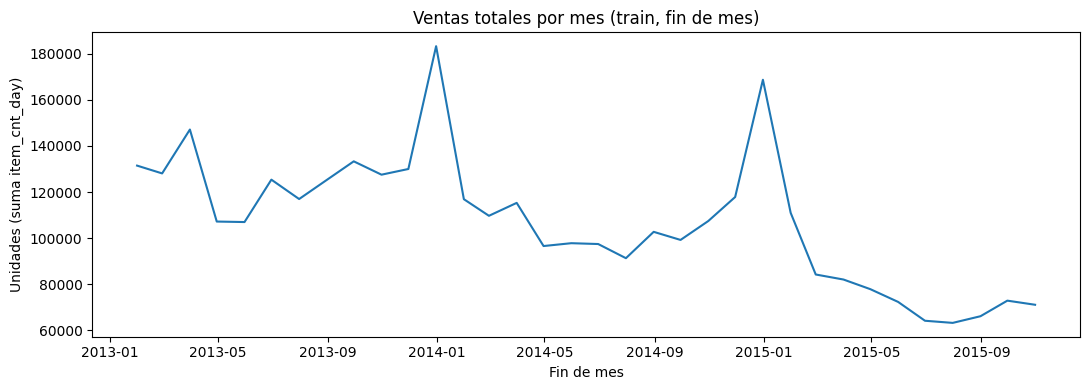

In [18]:
# Gráfica con nuestra predicción total
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y", errors="coerce")

global_month = (train.groupby("date_block_num", as_index=False)
                .agg(total_units=("item_cnt_day","sum"),
                     max_date=("date","max")))


global_month["max_date"] = pd.to_datetime(global_month["max_date"], errors="coerce")

global_month["month_end"] = global_month["max_date"] + pd.offsets.MonthEnd(0)


global_month = (train.groupby("date_block_num", as_index=False)
                .agg(total_units=("item_cnt_day","sum"),
                     max_date=("date","max")))
global_month["month_end"] = global_month["max_date"] + pd.offsets.MonthEnd(0)

plt.figure(figsize=(11,4))
plt.plot(global_month["month_end"], global_month["total_units"])
plt.title("Ventas totales por mes (train, fin de mes)")
plt.xlabel("Fin de mes")
plt.ylabel("Unidades (suma item_cnt_day)")
plt.tight_layout()
plt.show()

In [19]:
test.to_pickle("../data/inference/test.pkl")